In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sripaadsrinivasan/audio-mnist

100% 947M/948M [00:49<00:00, 22.7MB/s]
100% 948M/948M [00:49<00:00, 20.1MB/s]


In [ ]:
!unzip /content/audio-mnist.zip

In [ ]:
!pip install tensorflow_io -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 14.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import numpy as np

In [ ]:
60*500

30000

In [ ]:
# len(os.listdir("/content/data/60"))

In [ ]:
NEW_ROOT_DIR="final_data"
os.makedirs(NEW_ROOT_DIR,exist_ok=True)
[
    os.makedirs(os.path.join(NEW_ROOT_DIR,f'{i}'),exist_ok=True) for i in range(10)
]

In [ ]:
ROOT_DIR="/content/data"

In [ ]:
import shutil as sh
for dir in os.listdir(ROOT_DIR):
  p=os.path.join(ROOT_DIR,dir)
  for af in os.listdir(p):
    src_pa=os.path.join(p,af)
    des_pa=os.path.join(NEW_ROOT_DIR,af[0])
    sh.move(src_pa,des_pa)
  print(f"all file moved successfully dir name {p}")


In [ ]:
def data_loader(filename,lab):
  str_aud=tf.io.read_file(filename)
  wav,sample_rate=tf.audio.decode_wav(str_aud,desired_channels=1)
  print(wav.shape)
  wav=tf.squeeze(wav,axis=-1)
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)
  wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
  return wav,lab

In [ ]:
# os.listdir("final_data/0")[1]

In [ ]:
wav_0,lab_0=data_loader("final_data/0/0_41_21.wav","")
wav_1,lab_1=data_loader("final_data/1/1_41_21.wav","")

(32324, 1)
(32500, 1)


In [ ]:
wav_1.shape

TensorShape([10833])

In [ ]:
import IPython
audio_play=lambda fp: IPython.display.Audio(fp)
audio_play("/content/data/60/0_60_43.wav")

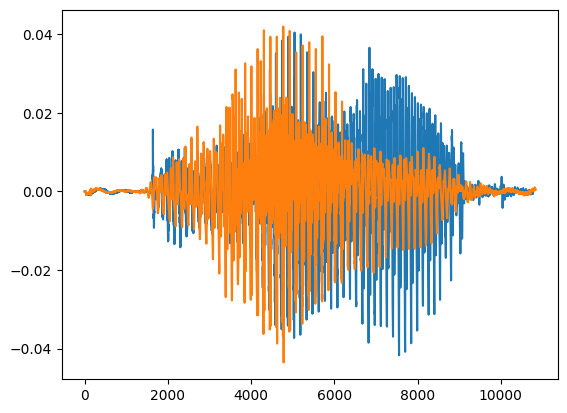

In [ ]:
plt.plot(wav_0)
plt.plot(wav_1)
plt.show()

In [ ]:
fp=tf.data.Dataset.list_files("final_data/0"+"/*.wav")

In [ ]:
fp_with_lab=tf.data.Dataset.zip((fp,tf.data.Dataset.from_tensor_slices(tf.zeros(len(fp)))))

In [ ]:
# list(fp_with_lab.take(1))

[(<tf.Tensor: shape=(), dtype=string, numpy=b'final_data/0/0_24_31.wav'>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)]

In [ ]:
for dir in range(1,10):
  dp=os.path.join(NEW_ROOT_DIR,str(dir))
  f_con=tf.data.Dataset.list_files(dp+"/*.wav")
  f_con_with_lab=tf.data.Dataset.zip((f_con,tf.data.Dataset.from_tensor_slices(dir*tf.ones(len(f_con)))))
  fp_with_lab=fp_with_lab.concatenate(f_con_with_lab)

In [ ]:
all_data_file=fp_with_lab

In [ ]:
len(all_data_file)

26000

In [ ]:
list(all_data_file.take())

[(<tf.Tensor: shape=(), dtype=string, numpy=b'final_data/0/0_04_6.wav'>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)]

In [ ]:
# for dir in os.listdir(NEW_ROOT_DIR):
#   dp=os.path.join(NEW_ROOT_DIR,dir)
#   print([os.path.join(dp,f) for f in os.listdir(dp) if not f.endswith(".wav")])
#   print("====="*20)

In [ ]:
data_map=all_data_file.map(data_loader)

In [ ]:
all_data_len=[len(d[0])for d in data_map]

In [ ]:
max(all_data_len)

15997

In [ ]:
MIN_WAV_LEN=16000
def process(filename,lab):
  wav,lab=data_loader(filename,lab)
  wav=wav[:MIN_WAV_LEN]
  # zero_pad=tf.expand_dims(tf.zeros(MIN_WAV_LEN-len(wav)),axis=0)
  zero_pad=tf.zeros(MIN_WAV_LEN-len(wav))
  print(wav.shape,zero_pad.shape)
  # if zero_pad.shape[1]>0:
  wav=tf.concat([zero_pad,wav],0)
  spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram=tf.abs(spectrogram)
  spectrogram=tf.expand_dims(spectrogram,axis=2)
  return spectrogram,lab

In [ ]:
wav_0,lab_0=process("final_data/0/0_41_21.wav","0")
wav_1,lab_1=process("final_data/1/1_41_21.wav","1")

(32324, 1)
(10774,) (5226,)
(32500, 1)
(10833,) (5167,)


In [ ]:
wav_0.shape

TensorShape([491, 257, 1])

In [ ]:
final_data=all_data_file.map(process)

(None, 1)
<unknown> (None,)


In [ ]:
final_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
((16000 - 320) // 32) + 1

491

In [ ]:
wav_1.shape

TensorShape([491, 257, 1])

In [ ]:
wav_0.shape

TensorShape([491, 257, 1])

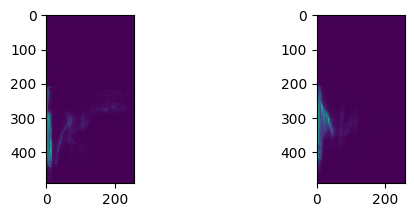

In [ ]:
plt.subplot(2,2,1)
plt.imshow(wav_0)
plt.subplot(2,2,2)
plt.imshow(wav_1)

In [ ]:
TOTAL_LEN=len(final_data)
TOTAL_LEN

28600

In [ ]:
TRAIN_DATA_RATIO=0.8
VAL_DATA_RATIO=0.1
TEST_DATA_RATIO=0.1
train_data=final_data.take(int(TOTAL_LEN*TRAIN_DATA_RATIO))
test_data=final_data.skip(int(TOTAL_LEN*TRAIN_DATA_RATIO)).take(int(TOTAL_LEN*TEST_DATA_RATIO))
val_data=final_data.skip(int(TOTAL_LEN*TRAIN_DATA_RATIO)+int(TOTAL_LEN*TEST_DATA_RATIO))

In [ ]:
final_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Input

In [ ]:
in_shape=(491, 257, 1)

In [ ]:
no_classes=len(os.listdir(NEW_ROOT_DIR))
no_classes

10

In [ ]:
model=Sequential(
    [
     Input(shape=in_shape),

     Conv2D(8,3,activation="relu"),
     Conv2D(16,3,activation="relu"),
     Conv2D(32,3,activation="relu",strides=2),
     Conv2D(64,3,activation="relu",strides=2),
     Conv2D(128,3,activation="relu",strides=2),
     Conv2D(128,3,activation="relu",strides=2),
     Conv2D(128,3,activation="relu",strides=2),

     Flatten(),
     Dense(16,activation="relu"),
     Dense(no_classes,activation="softmax")
    ]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 489, 255, 8)       80        
                                                                 
 conv2d_8 (Conv2D)           (None, 487, 253, 16)      1168      
                                                                 
 conv2d_9 (Conv2D)           (None, 243, 126, 32)      4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 121, 62, 64)       18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 30, 128)       73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 29, 14, 128)       147584    
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 6, 128)       

In [ ]:
train_data=train_data.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_data=val_data.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
test_data=test_data.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
)

In [ ]:
def lr_secheduler(epoch,lr):
  if epoch<=3:
    return lr
    return lr/10.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
ckpt_cb=ModelCheckpoint(
    "ckpt",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True
)
lr_se=LearningRateScheduler(lr_secheduler)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
model.fit(train_data,validation_data=val_data,epochs=5,callbacks=[ckpt_cb])

Epoch 1/5
715/715 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9406
Epoch 1: val_loss did not improve from 0.00000
715/715 [==============================] - 400s 548ms/step - loss: 0.2513 - accuracy: 0.9406 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 2/5
715/715 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8769
Epoch 2: val_loss did not improve from 0.00000
715/715 [==============================] - 397s 544ms/step - loss: 0.3281 - accuracy: 0.8769 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 3/5
715/715 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8766
Epoch 3: val_loss did not improve from 0.00000
715/715 [==============================] - 390s 536ms/step - loss: 0.3135 - accuracy: 0.8766 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 4/5
715/715 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.8790
Epoch 4: val_loss did not improve from 0.00000
715/715 [==================

In [ ]:
# spec,lab=test_data.take(1).as_numpy_iterator().next()

In [ ]:
len(test_data)

90

In [ ]:
fp="final_data/9/9_60_43.wav"
audio_play(fp)

In [ ]:
wav,lab=process(fp,"1")

(35814, 1)
(11938,) (4062,)


In [ ]:
wav.shape

TensorShape([491, 257, 1])

In [ ]:
out=model.predict(tf.expand_dims(wav,axis=0))

1/1 [==============================] - 0s 19ms/step


In [ ]:
# model.evaluate(test_data)

In [ ]:
tf.math.argmax(out,axis=-1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

In [ ]:
out.shape

(1, 10)

In [ ]:
tf.math.argmax(tf.constant([[1,2,3],[4,5,6]]),axis=1)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>